# Implementation of the Quantum Gradient Algorithm

Given a d-dimensional function f:
\begin{equation}
f(\vec{x}) = y
\end{equation}
The Quantum Gradient Algorithm aims to estimate the gradient of this function at the origin. The problem statement of this problem includes oracular access to an operation $U_f$, defined as such:
\begin{equation}
U_f: \ket{\vec{x_1}}\ket{\vec{x_2}}\ket{0} \rightarrow \ket{\vec{x_1}}\ket{\vec{x_2}}\ket{\vec{f(x_1, x_2)}}
\end{equation}
Put in words, this function takes as input d registers of q qubits plus an output register, and applies the modular addition of the function evaluation of the input registers onto the output register.

## Defining the Oracle Matrix

To test the algorithm with a simple function, define f as:
\begin{equation}
f(x_1, x_2) = x_1 + x_2
\end{equation}
This function is linear and two-dimensional, and two registers of 4 qubits will be used as input.

In [102]:
import numpy as np
from quantumreg import QuantumRegister, QuantumGate
from util import binaryArray2Int, int2BinaryArray
import matplotlib.pyplot as plt

q = 2

# The function f is defined as such
def f(x1, x2):
    return x1 + x2

# Another function is defined to perform the bitwise action of applying the oracle to a set of input and output registers.
def applyMatrix(vec):
    x1 = binaryArray2Int(vec[0:0+q])
    x2 = binaryArray2Int(vec[q:2*q])
    y = binaryArray2Int(vec[2*q:3*q])
    new_y = (y + f(x1, x2)) % (2**q)
    output_binary = int2BinaryArray(new_y, q)
    
    for i, b in enumerate(output_binary):
        vec[2*q+i] = b
        
    return vec

In order to apply $U_f$ in this implementation, its matrix representation is needed. Just as with any operator on a quantum system, its matrix elements can be defined as follows:
\begin{equation}
(U_f)_{ij} = \bra{i}U_f\ket{j}
\end{equation}
The following routine passes the bit representation of every basis state and applies the behavior of the oracle to it. The resulting bit representation is then converted to the state vector representation. The inner product of this state vector with every other state vector is then found to define the row of matrix elements.

In [103]:
Uf_mat = [[0 for j in range(2**(3*q))] for k in range(2**(3*q))]

for j in range(2**(3*q)):
    for k in range(2**(3*q)):
        leftbits = int2BinaryArray(j, 3*q)
        rightbits = int2BinaryArray(k, 3*q)
        Ufrightbits = applyMatrix(rightbits)
        bra = QuantumRegister(bits=leftbits).bits.transpose()
        ket = QuantumRegister(bits=Ufrightbits).bits
        Ufjk = np.dot(bra, ket)[0][0]
        Uf_mat[j][k] = Ufjk

## Defining Other Necessary Operations

The rest of this algorithm involves the use of hadamard gates and the quantum fourier transform. Both of these operations have known matrix elements that can be "hard-coded." These operations can be made to act only on certain bits by taking the tensor product of their matrix representations with the identity matrix.

In [104]:
# d input registers of q qubits each
d = 2 
q = 2 

hadamard = QuantumGate(np.divide(np.array([[1,1],[1,-1]]), np.sqrt(2)))

identity = QuantumGate(np.array([[1,0],[0,1]]))

qft = QuantumGate([[0 for j in range(2**q)] for k in range(2**q)])
def w_n(n: int):
    return np.exp(2*np.pi*1.j / (2**n))
for j in range(2**q):
    for k in range(2**q):
        qft[j][k] = 1/np.sqrt(2**q) * w_n(j*k)
        
qft_dag = QuantumGate(np.array(qft.mat).conj().transpose())

In [105]:
# step one: apply hadamard to input registers
one = (hadamard**(d*q)) * (identity**q)

# step two: apply qft to output registers
two = (identity**(d*q)) * (qft)

# step three: apply the oracle
Uf = QuantumGate(Uf_mat)

# step four: apply inverse qft to input registers
four = ((qft_dag**2) * (identity**q))

In [106]:
input = QuantumRegister(bits=[0,0,0,0,1,1])

input = one*input
input = two*input
input = Uf*input
input = four*input
print(input)

[[ 0.46277703+1.02174432e-01j]
 [ 0.46277703+1.02174432e-01j]
 [ 0.46277703+1.02174432e-01j]
 [ 0.46277703+1.02174432e-01j]
 [ 0.12541386-1.79440391e-01j]
 [ 0.12541386-1.79440391e-01j]
 [ 0.12541386-1.79440391e-01j]
 [ 0.12541386-1.79440391e-01j]
 [ 0.3755414 -9.67451184e-02j]
 [ 0.3755414 -9.67451184e-02j]
 [ 0.3755414 -9.67451184e-02j]
 [ 0.3755414 -9.67451184e-02j]
 [ 0.44920438+1.18268021e-16j]
 [ 0.44920438+1.15972036e-16j]
 [ 0.44920438+1.18295922e-16j]
 [ 0.44920438+1.15124256e-16j]
 [ 0.12541386-1.79440391e-01j]
 [ 0.12541386-1.79440391e-01j]
 [ 0.12541386-1.79440391e-01j]
 [ 0.12541386-1.79440391e-01j]
 [-0.09174353-4.73473326e-02j]
 [-0.09460899-1.15004164e-01j]
 [-0.01729112-1.41947815e-01j]
 [-0.01399928-3.66790567e-02j]
 [ 0.00130118-1.84793133e-01j]
 [ 0.03108341-1.98401266e-01j]
 [ 0.06158328-1.80708215e-01j]
 [ 0.00642575-1.45595793e-01j]
 [ 0.07170594-1.99980258e-01j]
 [ 0.08740608-1.98983988e-01j]
 [ 0.09658874-1.85586581e-01j]
 [ 0.06193471-1.82289018e-01j]
 [ 0.375

In [111]:
hist = [0 for i in range(2**(3*q))]
xaxis = [i for i in range(2**(3*q))]

for i in range(100):
    result = input.measure()
    hist[result] += 1

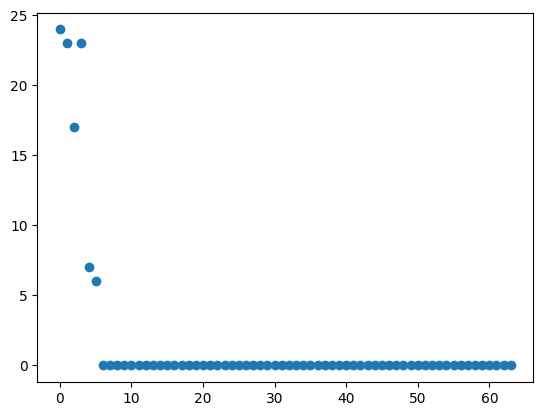

In [112]:
plt.scatter(xaxis, hist)

In [113]:
binaryArray2Int([0,1,0,1,0,0])

20